In [26]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve

In [27]:
# Load the finalized dataset
df = pd.read_csv("../Datasets/pokedex_final.csv")

# Combine type1 and type2 into a list
df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t) and t != ''])

# Encode the types with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['type_list'])

# Tokenize the enhanced_info column
text_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['enhanced_info'])

sequences = text_tokenizer.texts_to_sequences(df['enhanced_info'])
X_text = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Normalize numeric features
stats_cols = ['hp', 'attack', 'defense', 's_attack', 'speed', 'height', 'weight']
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stats_cols])

In [28]:
# Text input
input_text = Input(shape=(300,), name='text_input')
text_embed = Embedding(input_dim=5000, output_dim=64, input_length=300)(input_text)

# >>>>> CHANGE: Make LSTM Bidirectional
text_lstm = Bidirectional(LSTM(128, dropout=0.2))(text_embed)

# Stats input
input_stats = Input(shape=(X_stats.shape[1],), name='stats_input')

# Combine
combined = Concatenate()([text_lstm, input_stats])
hidden = Dense(256, activation='relu')(combined)
output = Dense(len(mlb.classes_), activation='sigmoid')(hidden)

model = Model(inputs=[input_text, input_stats], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Calculate class weights based on label frequency
class_totals = y.sum(axis=0)
class_weights = y.shape[0] / (len(mlb.classes_) * class_totals)

# Convert class weights to numpy array
class_weights = np.array(class_weights)

# Print class weights to check
print(dict(zip(mlb.classes_, class_weights)))

# Train the model with class weights
history = model.fit(
    [X_train_text, X_train_stats],
    y_train,
    validation_data=([X_test_text, X_test_stats], y_test),
    epochs=50,
    batch_size=32,
    class_weight=dict(enumerate(class_weights))  # Add this line!
)

# Existing thresholds array from your print output
best_thresholds = np.array([
    0.00011168035,  # bug
    0.0068565095,   # dark
    0.4838073,      # dragon
    0.5673274,      # electric
    0.95357776,     # fairy (lower this)
    0.09692402,     # fighting
    0.8846717,      # fire
    0.50269645,     # flying
    0.21124707,     # ghost (lower threshold)
    0.012433319,    # grass
    0.0006223337,   # ground
    0.14771947,     # ice (lower threshold)
    4.798732e-05,   # normal
    0.13341801,     # poison
    0.023951944,    # psychic
    0.024210032,    # rock
    0.0923449,      # steel (lower threshold)
    0.007665712     # water
])

# Adjust the threshold for specific types based on their frequencies
fairy_idx = list(mlb.classes_).index('fairy')
best_thresholds[fairy_idx] = 0.5  # Lower threshold for fairy (to make it easier to predict)

ice_idx = list(mlb.classes_).index('ice')
best_thresholds[ice_idx] = 0.3  # Lower threshold for ice

ghost_idx = list(mlb.classes_).index('ghost')
best_thresholds[ghost_idx] = 0.3  # Lower threshold for ghost

steel_idx = list(mlb.classes_).index('steel')
best_thresholds[steel_idx] = 0.4  # Lower threshold for steel

dragon_idx = list(mlb.classes_).index('dragon')
best_thresholds[dragon_idx] = 0.4  # Lower threshold for dragon

dark_idx = list(mlb.classes_).index('dark')
best_thresholds[dark_idx] = 0.4  # Lower threshold for dark

electric_idx = list(mlb.classes_).index('electric')
best_thresholds[electric_idx] = 0.4  # Lower threshold for electric

# Optionally, slightly increase thresholds for common types (if needed)
water_idx = list(mlb.classes_).index('water')
best_thresholds[water_idx] = 0.6  # Slightly increase for water (optional)

normal_idx = list(mlb.classes_).index('normal')
best_thresholds[normal_idx] = 0.6  # Slightly increase for normal (optional)


# Save model and label binarizer
model.save("rnn_stats_pokemon_model.keras")
pd.DataFrame(mlb.classes_, columns=['Type']).to_csv("type_classes.csv", index=False)

c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 300, 64)   │    320,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    197,632 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 263)       │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     67,584 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 18)        │      4,626 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 589,842 (2.25 MB)

 Trainable params: 589,842 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

{'bug': 0.6189613526570048, 'dark': 0.8252818035426731, 'dragon': 0.8134920634920635, 'electric': 0.8252818035426731, 'fairy': 0.8897569444444444, 'fighting': 0.7800608828006088, 'fire': 0.7030178326474623, 'flying': 0.5224260958205912, 'ghost': 0.8760683760683761, 'grass': 0.4483814523184602, 'ground': 0.7592592592592593, 'ice': 1.1863425925925926, 'normal': 0.43469041560644617, 'poison': 0.6860776439089692, 'psychic': 0.5582788671023965, 'rock': 0.7695195195195195, 'steel': 0.8760683760683761, 'water': 0.36976911976911975}
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.0476 - loss: 0.3592 - val_accuracy: 0.0878 - val_loss: 0.2921
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.1002 - loss: 0.1947 - val_accuracy: 0.1366 - val_loss: 0.2825
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.1141 - loss: 0.1936 - val_accuracy: 0.0585 - val_loss: 0.2790
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.1318 - loss: 0.188

In [29]:
# Load model
model = tf.keras.models.load_model("rnn_stats_pokemon_model.keras")

# Predict probabilities
y_pred_probs = model.predict([X_test_text, X_test_stats])

# >>>>> CHANGE: Find best threshold for each class individually
best_thresholds = []

for i in range(y.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1)]
    best_thresholds.append(best_threshold)

best_thresholds = np.array(best_thresholds)

# Apply best thresholds
y_pred = (y_pred_probs > best_thresholds).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


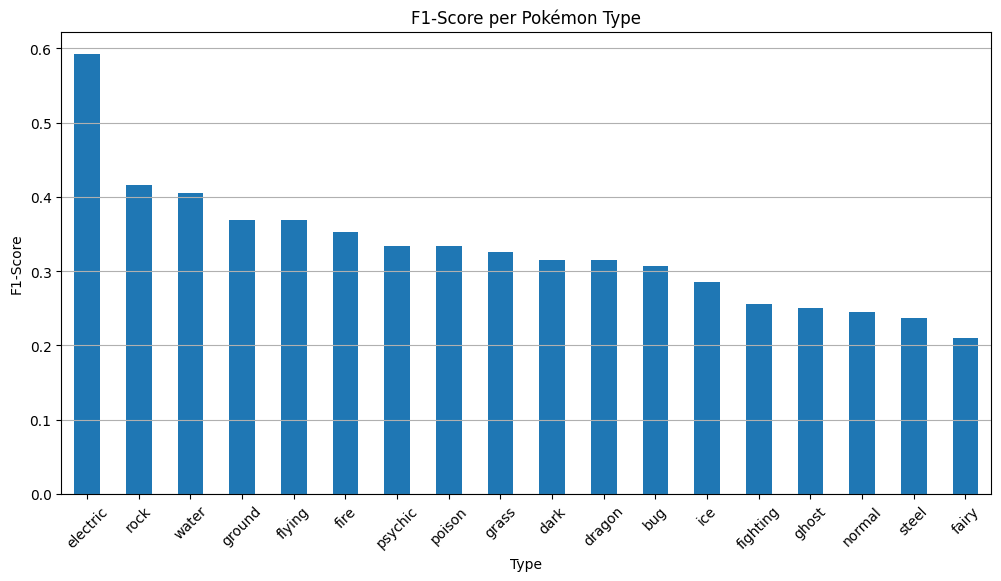

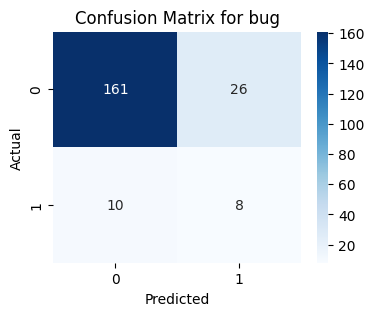

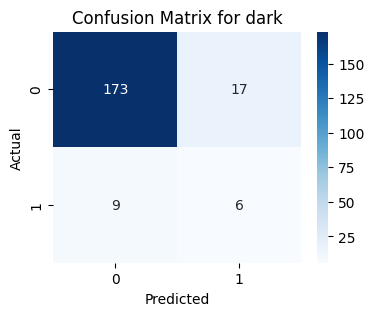

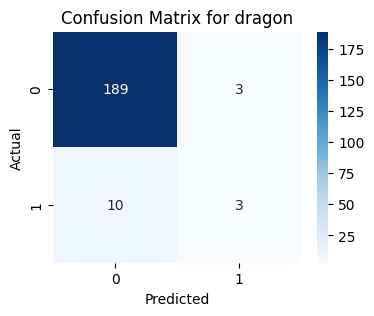

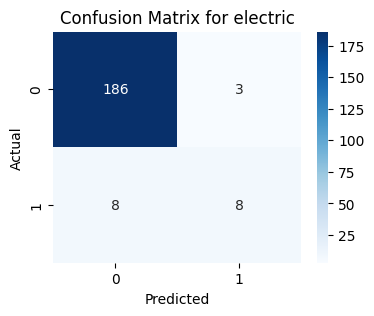

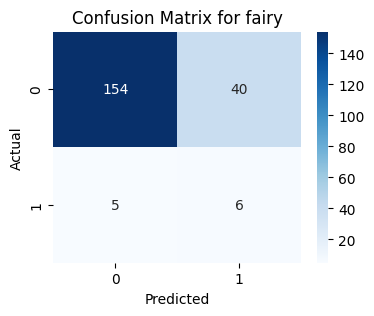

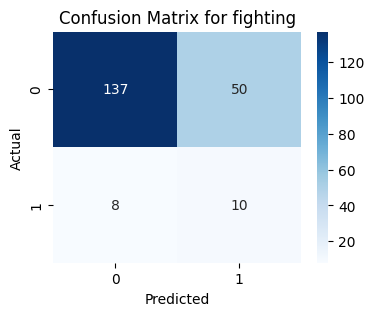

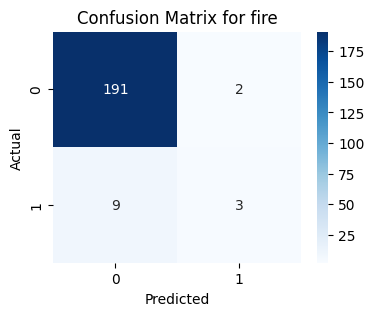

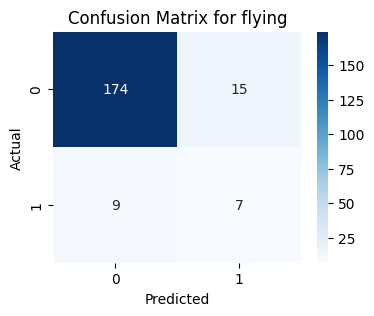

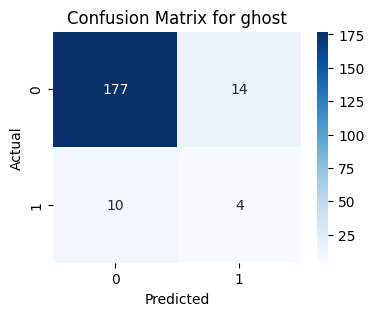

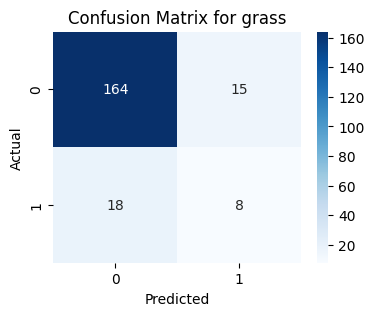

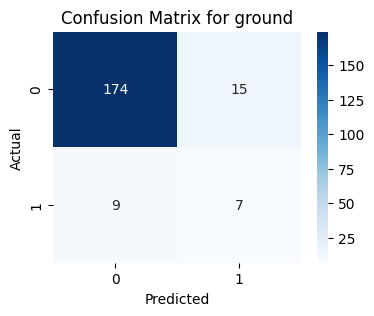

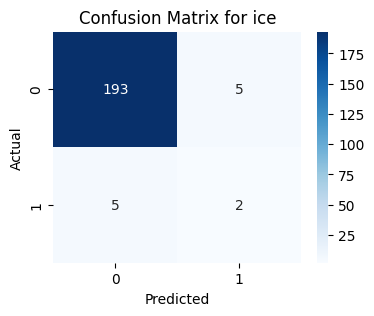

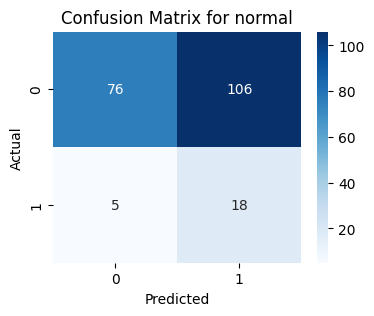

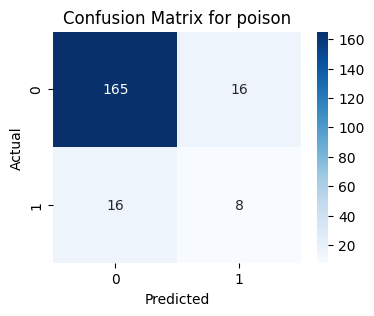

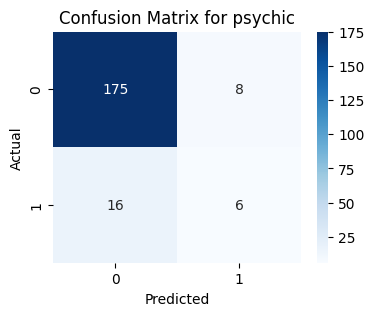

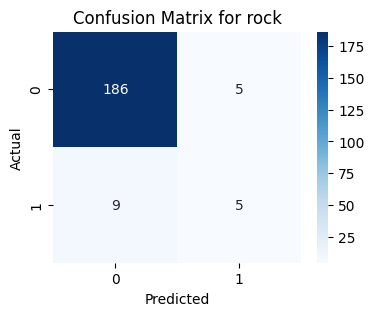

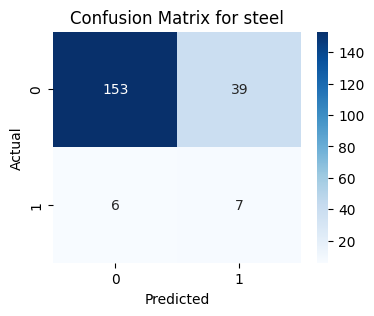

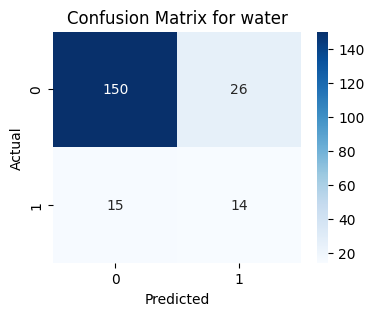

In [30]:
# Classification report
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

# Convert report to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Display F1 scores per type
f1_scores = report_df.loc[mlb.classes_, 'f1-score']
plt.figure(figsize=(12,6))
f1_scores.sort_values(ascending=False).plot(kind='bar')
plt.title('F1-Score per Pokémon Type')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Confusion matrices
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

for idx, type_name in enumerate(mlb.classes_[:18]):
    cm = conf_matrices[idx]
    plt.figure(figsize=(4,3))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {type_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [22]:
y_pred_probs = model.predict([X_test_text, X_test_stats])
print("Max prob:", np.max(y_pred_probs))
print("Mean prob:", np.mean(y_pred_probs))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Max prob: 0.99999976
Mean prob: 0.054800026


In [23]:
import numpy as np

pred_counts = y_pred.sum(axis=0)
true_counts = y_test.sum(axis=0)

for cls, pred, true in zip(mlb.classes_, pred_counts, true_counts):
    print(f"{cls:10s} | predicted: {pred:3d} | actual: {true:3d}")


bug        | predicted:  97 | actual:  18
dark       | predicted:  38 | actual:  15
dragon     | predicted:  11 | actual:  13
electric   | predicted:  13 | actual:  16
fairy      | predicted:   2 | actual:  11
fighting   | predicted:   9 | actual:  18
fire       | predicted:   9 | actual:  12
flying     | predicted:  20 | actual:  16
ghost      | predicted:   4 | actual:  14
grass      | predicted:  34 | actual:  26
ground     | predicted:  48 | actual:  16
ice        | predicted:   6 | actual:   7
normal     | predicted:  94 | actual:  23
poison     | predicted:  17 | actual:  24
psychic    | predicted:  28 | actual:  22
rock       | predicted:  29 | actual:  14
steel      | predicted:  11 | actual:  13
water      | predicted:  58 | actual:  29


In [16]:
import pandas as pd

df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t)])

all_types = pd.Series([t for sublist in df['type_list'] for t in sublist])
print(all_types.value_counts())


water       154
normal      131
grass       127
flying      109
psychic     102
bug          92
poison       83
fire         81
ground       75
rock         74
fighting     73
dragon       70
dark         69
electric     69
steel        65
ghost        65
fairy        64
ice          48
dtype: int64


In [24]:
print(dict(zip(mlb.classes_, best_thresholds)))

{'bug': 0.00011168035, 'dark': 0.0068565095, 'dragon': 0.4838073, 'electric': 0.5673274, 'fairy': 0.95357776, 'fighting': 0.09692402, 'fire': 0.8846717, 'flying': 0.50269645, 'ghost': 0.21124707, 'grass': 0.012433319, 'ground': 0.0006223337, 'ice': 0.14771947, 'normal': 4.798732e-05, 'poison': 0.13341801, 'psychic': 0.023951944, 'rock': 0.024210032, 'steel': 0.0923449, 'water': 0.007665712}


In [31]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test (true labels) and y_pred (predicted labels) are already defined
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

# Convert the classification report into a DataFrame for better readability
report_df = pd.DataFrame(report).transpose()

# Extract the F1 scores for each type (both per-class and averages)
f1_scores_per_type = report_df['f1-score']

# Print F1 scores for each class
print("F1 Scores per Pokémon Type:")
print(f1_scores_per_type)

# Print the average F1 scores
print("\nAverage F1 Scores:")
print(f"Macro Average F1: {report_df.loc['macro avg', 'f1-score']:.4f}")
print(f"Weighted Average F1: {report_df.loc['weighted avg', 'f1-score']:.4f}")

# Optionally, you can also return the DataFrame if you need it in a different format
# report_df.to_csv('f1_scores_per_type.csv')  # Save as CSV if needed


F1 Scores per Pokémon Type:
bug             0.307692
dark            0.315789
dragon          0.315789
electric        0.592593
fairy           0.210526
fighting        0.256410
fire            0.352941
flying          0.368421
ghost           0.250000
grass           0.326531
ground          0.368421
ice             0.285714
normal          0.244898
poison          0.333333
psychic         0.333333
rock            0.416667
steel           0.237288
water           0.405797
micro avg       0.308789
macro avg       0.329008
weighted avg    0.333746
samples avg     0.297631
Name: f1-score, dtype: float64

Average F1 Scores:
Macro Average F1: 0.3290
Weighted Average F1: 0.3337


c:\Users\arvee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
